### Singular Value Thresholding

In [1]:
pip install sparsesvd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sparsesvd: filename=sparsesvd-0.2.2-cp38-cp38-linux_x86_64.whl size=329589 sha256=1d4caf98f85ec84dce09d54606ea4a3bd6f57dfc66b7c2205cba4f74f3852d86
  Stored in directory: /root/.cache/pip/wheels/9a/90/46/8ba8493c6eaa5343837a43aad621862d76fdb5b8434c588c26
Successfully built sparsesvd


In [2]:
import os
import numpy as np
import scipy.sparse as ss

path_prefix = '/content/'
def dataloader(dataset = 'ratings'):
    filename = path_prefix + dataset+'.dat'
    users = []
    movies = []
    ratings = []
    max_uid = 0
    max_vid = 0
    first_line_flag = True
    with open(filename) as f:
        for line in f:
            tokens = line.strip().split('::')
            # tokens = m
            if first_line_flag:
                max_uid = int(tokens[0])
                max_vid = int(tokens[1])
                first_line_flag = False
                continue
            max_uid = max(max_uid, int(tokens[0]))
            max_vid = max(max_vid, int(tokens[1]))
            users.append((int(tokens[0]) - 1))
            movies.append(int(tokens[1]) - 1)
            ratings.append(int(tokens[2]))
    M_ori = ss.csr_matrix((ratings, (users, movies)), shape=(max_uid, max_vid))
    return M_ori

In [8]:
from numpy.lib.function_base import append
import numpy as np
from numpy import linalg as la
from sparsesvd import sparsesvd
from scipy.sparse.linalg import norm
import scipy.sparse as ss
import scipy.io
import random

def SVT(M1, iter_num):
    #parameters
    n1, n2 = M1.shape
    total_num = len(M1.nonzero()[0])
    proportion = 1.0
    idx = random.sample(range(total_num), int(total_num * proportion))
    Omega = (M1.nonzero()[0][idx], M1.nonzero()[1][idx])
    p = 0.5
    tau = 20000
    delta = 2
    maxiter = iter_num
    tol = 0.001
    incre = 5

    # the Svd
    r = 0
    b = M1[Omega]
    P_Omega_M = ss.csr_matrix((np.ravel(b), Omega), shape=(n1, n2))
    normProjM = norm(P_Omega_M)
    k0 = np.ceil(tau / (delta * normProjM))
    Y = k0 * delta * P_Omega_M
    iternum = 0
    rmse = []
    rmse_list = []

    for k in range(maxiter+1):
        s = r + 1
        while True:
            u1, s1, v1 = sparsesvd(ss.csc_matrix(Y), s)
            if s1[s - 1] <= tau: break
            s = min(s + incre, n1, n2)
            if s == min(n1, n2): break

        r = np.sum(s1 > tau)
        U = u1.T[:, :r]
        V = v1[:r, :]
        S = s1[:r] - tau
        x = (U * S).dot(V)
        x_omega = ss.csr_matrix((x[Omega], Omega), shape=(n1, n2))

        if norm(x_omega - P_Omega_M) / norm(P_Omega_M) < tol:
            break

        diff = P_Omega_M - x_omega
        Y += delta * diff
        this_rmse = float(la.norm(M1[M1.nonzero()] - x[M1.nonzero()]) / np.sqrt(len(x[M1.nonzero()])))
        
        #rela_err = float(la.norm(M1[M1.nonzero()] - x[M1.nonzero()])/la.norm(M1[M1.nonzero()] ))
        print('Iter %d , RMSE %.3f' % (iternum, this_rmse),s)
        rmse.append(this_rmse)
        iternum += 1
        if (k==0):
           continue
        if (k%50==0):
          rmse_list.append(this_rmse)

    return rmse_list

Iter 0 , RMSE 3.759 1
Iter 1 , RMSE 3.759 1
Iter 2 , RMSE 3.759 1
Iter 3 , RMSE 3.759 1
Iter 4 , RMSE 3.759 1
Iter 5 , RMSE 3.759 1
Iter 6 , RMSE 3.759 1
Iter 7 , RMSE 2.919 6
Iter 8 , RMSE 2.621 2
Iter 9 , RMSE 2.571 2
Iter 10 , RMSE 2.522 2
Iter 11 , RMSE 2.475 2
Iter 12 , RMSE 2.429 2
Iter 13 , RMSE 2.385 2
Iter 14 , RMSE 2.343 2
Iter 15 , RMSE 2.302 2
Iter 16 , RMSE 2.262 2
Iter 17 , RMSE 2.224 2
Iter 18 , RMSE 2.188 2
Iter 19 , RMSE 2.153 2
Iter 20 , RMSE 2.120 2
Iter 21 , RMSE 2.088 2
Iter 22 , RMSE 2.058 2
Iter 23 , RMSE 2.028 2
Iter 24 , RMSE 2.000 2
Iter 25 , RMSE 1.973 2
Iter 26 , RMSE 1.947 2
Iter 27 , RMSE 1.922 2
Iter 28 , RMSE 1.899 2
Iter 29 , RMSE 1.876 2
Iter 30 , RMSE 1.853 2
Iter 31 , RMSE 1.832 2
Iter 32 , RMSE 1.812 2
Iter 33 , RMSE 1.792 2
Iter 34 , RMSE 1.773 2
Iter 35 , RMSE 1.755 2
Iter 36 , RMSE 1.737 2
Iter 37 , RMSE 1.720 2
Iter 38 , RMSE 1.703 2
Iter 39 , RMSE 1.687 2
Iter 40 , RMSE 1.672 2
Iter 41 , RMSE 1.657 2
Iter 42 , RMSE 1.642 2
Iter 43 , RMSE 1.628 

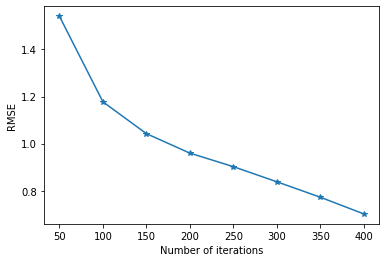

Time:-419.314545 s


In [9]:
import time
import matplotlib.pyplot as plt
#parameters
num_of_entries = 6050
iter = 400
plot = True

start = time.perf_counter()
M_ori = dataloader('ratings')
M1 = M_ori[:num_of_entries]
#print(M1.getnnz())
iter_list = [50,100,150,200,250,300,350,400]

s = 1
#for i in iter_list:
    
rmse=SVT(M1, iter)
print("The %d iteration is completed"%s)
s += 1
if plot:
    plt.plot(iter_list,rmse,'*-')
    #plt.plot(iter_list, rmse, '*-')
    plt.xlabel('Number of iterations')
    plt.ylabel('RMSE')
    plt.show()
print("Time:%f s" %(time.process_time() - start))

Stochastic Gradient Descent 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from random import sample
from numpy.lib.function_base import append
import numpy as np
from numpy import linalg as la
from sparsesvd import sparsesvd
from scipy.sparse.linalg import norm
import scipy.sparse as ss
import scipy.io

In [ ]:
columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ratings.dat', sep='::', engine='python', names=columns)
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
train, test = train_test_split(ratings, stratify=ratings['user_id'], test_size=0.2, random_state=9)

In [ ]:
counts_train = train.groupby('user_id').count()
counts_test = test.groupby('user_id').count()

check = counts_test / (counts_test + counts_train)
check.head()

,movie_id,rating,unix_timestamp
user_id,,,
1,0.207547,0.207547,0.207547
2,0.201550,0.201550,0.201550
3,0.196078,0.196078,0.196078
4,0.190476,0.190476,0.190476
5,0.202020,0.202020,0.202020


In [ ]:
num_users = train['user_id'].max()
num_movies = train['movie_id'].max()

matrix = np.empty([num_users, num_movies])
matrix[:] = np.nan
matrix

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
columns = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ratings.dat', sep='::', engine='python', names=columns)
counts_train = ratings.groupby('user_id').count()
num_users = ratings['user_id'].max()
num_movies = ratings['movie_id'].max()

matrix = np.empty([num_users, num_movies])
matrix[:] = np.nan

for _, row in ratings.iterrows():
    matrix[row['user_id'] - 1, row['movie_id'] - 1] = row['rating']
matrix

array([[ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 3., nan, nan, ..., nan, nan, nan]])

In [ ]:
for _, row in train.iterrows():
    matrix[row['user_id'] - 1, row['movie_id'] - 1] = row['rating']
matrix

array([[ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 3., nan, nan, ..., nan, nan, nan]])

In [ ]:
import sys


class SGD():

    def solve(self, X, K, max_iter=100, batch_size=100,
              learning_rate=0.01, validation_size=0.1,
              verbose=0, early_stopping=False, patience=3,
              random_state=None):

        mask = np.invert(np.ma.masked_invalid(matrix).mask).astype(int)
        N = mask.sum()
        rmse = []

        if verbose:
            print(f'{100 * N / (matrix.shape[0] * matrix.shape[1]):.2f}% of the matrix is full')

        # create a list of non-missing elements in the matrix, will be useful later
        Xlist = list(zip(list(np.where(mask == 1)[0]),
                         list(np.where(mask == 1)[1]),
                         matrix[np.where(mask == 1)]))

        if validation_size > 0:
            Xlist_train, Xlist_validate = train_test_split(
                Xlist, test_size=validation_size, random_state=random_state)
        else:
            Xlist_train = Xlist
            Xlist_validate = []

        N_train = len(Xlist_train)
        N_validate = len(Xlist_validate)

        matrix_train = np.empty(X.shape)
        matrix_train[:] = np.nan
        matrix_validate = np.empty(X.shape)
        matrix_validate[:] = np.nan

        for element in Xlist_train:
            matrix_train[element[0], element[1]] = element[2]

        for element in Xlist_validate:
            matrix_validate[element[0], element[1]] = element[2]

        I, J = matrix.shape

        W = np.random.random([I, K])
        H = np.random.random([K, J])

        eta = learning_rate


        # variables for early stopping
        best_val_loss = sys.float_info.max
        stopping_step = 0
        rmse_list = []

        for t in range(1, max_iter + 1):
            batch = sample(Xlist_train, batch_size)

            for element in batch:
                cur_i = element[0]
                cur_j = element[1]
                cur_x = element[2]

                cur_xhat = np.dot(W[cur_i, :], H[:, cur_j])

                # compute gradients
                grad_w = (cur_xhat - cur_x) * H[:, cur_j].T
                grad_h = (cur_xhat - cur_x) * W[cur_i, :].T

                # take a gradient step
                W[cur_i, :] = W[cur_i, :] - eta * grad_w
                H[:, cur_j] = H[:, cur_j] - eta * grad_h

            estimation = np.dot(W, H)

            this_rmse = float(la.norm(M_ori[M_ori.nonzero()] - estimation[M_ori.nonzero()]) / np.sqrt(len(estimation[M_ori.nonzero()])))
        
            #rela_err = float(la.norm(M1[M1.nonzero()] - x[M1.nonzero()])/la.norm(M1[M1.nonzero()] ))
            print('Iter %d , RMSE %.3f' % (t, this_rmse))
            if (t==0):
              break
            if (t%50==0):
              rmse_list.append(this_rmse)
            if this_rmse<0.8:
              break            
        
        self.W = W
        self.H = H

        return rmse_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


4.19% of the matrix is full
Iter 1 , RMSE 1.287
Iter 2 , RMSE 1.150
Iter 3 , RMSE 1.087
Iter 4 , RMSE 1.048
Iter 5 , RMSE 1.024
Iter 6 , RMSE 1.006
Iter 7 , RMSE 0.993
Iter 8 , RMSE 0.983
Iter 9 , RMSE 0.975
Iter 10 , RMSE 0.968
Iter 11 , RMSE 0.963
Iter 12 , RMSE 0.958
Iter 13 , RMSE 0.954
Iter 14 , RMSE 0.950
Iter 15 , RMSE 0.947
Iter 16 , RMSE 0.945
Iter 17 , RMSE 0.943
Iter 18 , RMSE 0.940
Iter 19 , RMSE 0.938
Iter 20 , RMSE 0.937
Iter 21 , RMSE 0.935
Iter 22 , RMSE 0.934
Iter 23 , RMSE 0.932
Iter 24 , RMSE 0.931
Iter 25 , RMSE 0.930
Iter 26 , RMSE 0.928
Iter 27 , RMSE 0.928
Iter 28 , RMSE 0.926
Iter 29 , RMSE 0.925
Iter 30 , RMSE 0.925
Iter 31 , RMSE 0.924
Iter 32 , RMSE 0.923
Iter 33 , RMSE 0.922
Iter 34 , RMSE 0.922
Iter 35 , RMSE 0.921
Iter 36 , RMSE 0.921
Iter 37 , RMSE 0.920
Iter 38 , RMSE 0.920
Iter 39 , RMSE 0.919
Iter 40 , RMSE 0.919
Iter 41 , RMSE 0.918
Iter 42 , RMSE 0.918
Iter 43 , RMSE 0.918
Iter 44 , RMSE 0.917
Iter 45 , RMSE 0.916
Iter 46 , RMSE 0.916
Iter 47 , RMSE 

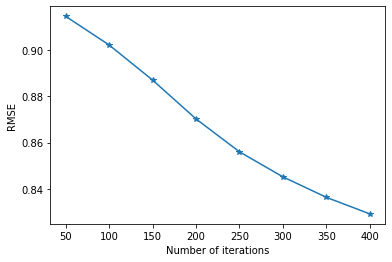

Time:565.214484 s
Time:565.215352 s


In [ ]:
import time
import matplotlib.pyplot as plt
num_of_entries = 1200
M_ori = dataloader('ratings')
M1 = M_ori[:num_of_entries]
start = time.clock()
iter = 400



sgd = SGD()
rmse = sgd.solve(M_ori, 10, max_iter=400,
                    batch_size=50000, learning_rate=0.005,
                    verbose=1, early_stopping=True,
                    patience=10, validation_size=0.1)
    
plot = True


iter_list = [50,100,150,200,250,300,350,400]

s = 1
#for i in iter_list:
    
print("The %d iteration is completed"%s)
s += 1
if plot:
    plt.plot(iter_list,rmse,'*-')
    #plt.plot(iter_list, rmse, '*-')
    plt.xlabel('Number of iterations')
    plt.ylabel('RMSE')
    plt.show()
print("Time:%f s" %(time.process_time() - start))
print("Time:%f s" %(time.process_time() - start))